In [298]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, hessian, jacobian
from jax import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import copy, timeit
#%matplotlib

In [2]:
def Rastrigin(x, A=20): # define objective (map from n dim to 1 dim)
    f = A * len(x) + jnp.sum(jnp.array([xi ** 2 - A * jnp.cos(2 * xi * jnp.pi) for xi in x]))
    return f

RastriginGrad = grad(Rastrigin) # use jacobian() if function map from n to m. 
#Here grad is less computational expensive that jacobian
RastriginGradSec = jacobian(grad(Rastrigin))
RastriginHess = hessian(Rastrigin) 
RastriginJac = jacobian(Rastrigin)
initial_x = np.random.rand(20)

### backtracking line search

In [3]:
def Backtracking(xi, func, p, grads, alpha_init=1., c=0.7, low= 0.7): # perform inexact line search
    a = alpha_init
    while True:
        if func(xi + a * p) <= func(xi) + c * a * jnp.dot(p, grads):
            return a
        else:
            a = low * a

### Implement Steepest descent 

The search direction is given by
$$p_k = - \frac{{\nabla}f(\textbf{x}_k)}{\parallel{\nabla}f(\textbf{x}_k)\parallel}$$
And general update rule is given by
$$x_{k+1} \leftarrow x_k + \alpha p_k$$

In [4]:
theshold = 0.1
X_k = initial_x #np.random.rand(20)
eval_first = Rastrigin(X_k)
alpha = 1.
while True:
    grad_k = RastriginGrad(X_k)
    grad_norm_k = jnp.linalg.norm(grad_k)
    direction_p = - grad_k / grad_norm_k
    alpha_k = Backtracking(X_k, Rastrigin, direction_p, grad_k)
    X_k = X_k + alpha_k * direction_p
    alpha_k = alpha
    print(alpha_k, grad_norm_k, Rastrigin(X_k))
    if grad_norm_k < theshold:
        break
print('frist evaluation', eval_first, 'final evaluation', Rastrigin(X_k))


1.0 147.31888 115.45373
1.0 95.1492 89.765144
1.0 98.36395 47.897034
1.0 100.5531 28.301117
1.0 68.56797 14.885178
1.0 58.62729 9.770447
1.0 24.938732 9.215057
1.0 14.2851715 9.008835
1.0 6.549005 8.9639435
1.0 2.7152522 8.957108
1.0 1.3973312 8.955353
1.0 0.7512998 8.95488
1.0 0.43471104 8.954742
1.0 0.27957657 8.954666
1.0 0.12444509 8.954651
1.0 0.07123309 8.954651
frist evaluation 166.91321 final evaluation 8.954651


### Newton Method 

The search direction is given by
$$p_k = - \frac{{\nabla}f(\textbf{x}_k)}{{\nabla}^2f(\textbf{x}_k)}$$

In [5]:
X_k = initial_x
eval_first = Rastrigin(X_k)
evalx = []
alpha = 1.

while True:
    evalx.append(X_k)
    G2 = np.diag(1 / np.diag(RastriginHess(X_k))) #np.linalg.pinv(RastriginHess(X_k))
    G1 = RastriginGrad(X_k) 
    direction_p =  - G2.dot(G1)
    alpha_k = Backtracking(X_k, Rastrigin, direction_p, G1, c=0.1, low= 0.8)
    X_k = X_k + alpha_k * direction_p
    alpha_k = alpha_k
    
    grad_norm_k = jnp.linalg.norm(G1)
    print(alpha_k, grad_norm_k, Rastrigin(X_k))
    if grad_norm_k < theshold*0.1:
        break
print('frist evaluation', eval_first, 'final evaluation', Rastrigin(X_k))

1.0 147.31888 151.47249
1.0 79.55184 150.27101
1.0 38.12523 148.77115
1.0 4.658138 148.7439
1.0 0.013915834 148.7439
1.0 3.095427e-05 148.7439
frist evaluation 166.91321 final evaluation 148.7439


### Example on linear regression

In [6]:
def least_squares(A, b, x): #GRAD : A.T.dot(A.dot(x)-b)/len(A), HESS : #A.T.dot(A)/len(A)
    return (0.5/len(A)) * jnp.linalg.norm(jnp.dot(A, x)-b)**2

ghk = jacobian(grad(least_squares, 2), 2)
gk = grad(least_squares ,2)

Ns = 100
Axxk = np.random.rand(1000, Ns)
xxk = np.random.rand(Ns, )
b = Axxk.dot(xxk)

xs = np.random.rand(Ns, ) 
print('first eval', least_squares(Axxk, b, xs))
for step in [1, 1]:
    Hinv = np.linalg.pinv(ghk(Axxk, b, xs).reshape(Ns, Ns))
    xs = xs - step * Hinv.dot(gk(Axxk, b, xs))
print('last eval', least_squares(Axxk, b, xs))

first eval 3.6861901
last eval 7.8034644e-13


### Newton's with by solving system of linear equation
$$p_k =  \mathbf{H}^{-1}_k{\nabla}f(\textbf{x}_k)$$
$$\mathbf{H}_k p_k = g_k$$

In [7]:
EPS = 0.00000001
def conjugate_gradient(Ax, b, max_iters=100, tol=0.001, CG_time_step=0):
    'A is (S++)'
    x = np.zeros_like(b)
    r = copy.deepcopy(b)  
    p = copy.deepcopy(r)
    r_dot_old = np.dot(r, r)

    for _ in range(max_iters):
        z = np.dot(Ax, p) # for hessian vector product use Ax(p) as a function 
        alpha = r_dot_old /( np.dot(p, z) + EPS)
        x += alpha * p
        r -= alpha * z
        CG_time_step+=1
        if tol >= np.linalg.norm(r):
            return x #CG_time_step
        
        r_dot_new = np.dot(r, r)
        p = r + (r_dot_new / (r_dot_old + EPS)) * p
        r_dot_old = r_dot_new

    return x #CG_time_step

In [8]:
grad_lg = grad(least_squares, 2)
hess_lg = lambda as_, bs, xs: jacobian(grad(least_squares, 2), 2)(as_, bs, xs).reshape(Ns, Ns)
#Hessian_vector_prod = lambda f

# def hvp(f, x, v):
#     return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)

def Newton_ls(func, gradf, hessf, x_init, solver=conjugate_gradient, max_iters=20):
    x = x_init
    alpha = 0.1 # use fix step size
    First_eval = func(Axxk, b, x)
    start = timeit.default_timer()
    
    for i in range(max_iters):
        G2 = hessf(Axxk, b, x)
        G1 = gradf(Axxk, b, x)
        assert np.all(np.linalg.eigvals(G2) > 0), 'hessian is not possitive-definite'
        direction_p = - solver(G2, G1)
        x = x + alpha * direction_p
    execution_time = timeit.default_timer() - start
    print('frist_eval : ', First_eval, 'last_eval', func(Axxk, b, x), 'time :', execution_time)
    return x

In [9]:
xs = np.random.rand(Ns, ) 
solver0 = lambda A, b: np.linalg.lstsq(A, b, rcond=None)[0]
#solver1 = grad least square
x_solved = Newton_ls(least_squares, grad_lg, hess_lg, xs, solver=conjugate_gradient) # using conjugate gradient.
x_solved = Newton_ls(least_squares, grad_lg, hess_lg, xs, solver=solver0) # using least squre.

frist_eval :  0.6886535 last_eval 0.010180488 time : 0.7253474929999975
frist_eval :  0.6886535 last_eval 0.010178898 time : 0.8021021949999998


### Approximate hessian newton method : BFGS

In [10]:
def Newton_bgfs(func, x, gradf, hessf, max_iters=20):
    First_eval = func(Axxk, b, x)
    
    I = np.eye(Ns) 
    G2_inv = I# initialize inverse H as identity
    alpha = 0.1 #fix search distance
    xss = []
    xss.append(x)
    
    for _ in range(max_iters):
        
        G2 = hessf(Axxk, b, x)
        G1 = gradf(Axxk, b, x)
        direction_p = - jnp.dot(G2_inv, G1)
        x = x + alpha * direction_p
        xss.append(x)
        
        s = xss[-1] - xss[-2]
        y = gradf(Axxk, b, xss[-1]) - gradf(Axxk, b, xss[-2])
        ys = jnp.dot(y, s)
        ssT = jnp.outer(s, s)
        
        G2 = G2 + np.outer(y, y)/ys
        G2 = G2 - G2.dot(ssT.dot(G2))/np.dot(s, G2.dot(s))

        
        left = I - np.outer(s, y)/ys
        right = I - np.outer(y, s)/ys
        G2_inv = (left.dot(G2_inv).dot(right) + ssT/ys)
        print('eval_function : ', func(Axxk, b, x), 'grad : ', np.linalg.norm(G1))
    last_eval = func(Axxk, b, x)
    return x, xss

In [11]:
xs = np.random.rand(Ns, ) 
xs_solved = Newton_bgfs(least_squares, xs, grad_lg, hess_lg, max_iters=20)

eval_function :  3.1413367 grad :  7.1612897
eval_function :  2.6830497 grad :  10.85475
eval_function :  2.2854056 grad :  9.772662
eval_function :  1.941838 grad :  8.768967
eval_function :  1.6461618 grad :  7.843107
eval_function :  1.3926367 grad :  6.9934034
eval_function :  1.1759866 grad :  6.2173057
eval_function :  0.99141794 grad :  5.5115523
eval_function :  0.83462334 grad :  4.8723717
eval_function :  0.7017573 grad :  4.2956653
eval_function :  0.5894216 grad :  3.7771199
eval_function :  0.49463367 grad :  3.3123631
eval_function :  0.41479173 grad :  2.8970504
eval_function :  0.34764308 grad :  2.5269356
eval_function :  0.2912425 grad :  2.1979585
eval_function :  0.24392174 grad :  1.9062487
eval_function :  0.20425588 grad :  1.6481763
eval_function :  0.17103091 grad :  1.4203701
eval_function :  0.14321744 grad :  1.2197078
eval_function :  0.119943924 grad :  1.0433307


## Time to re-invent the wheel !!

toy example neural network for classification.

In [1132]:
import tensorflow_datasets as tfds
(ds_train, ds_test) = tfds.load('mnist',split=['train', 'test'],shuffle_files=True,as_supervised=True)
X_data = np.asarray([i[0] for i in tfds.as_numpy(ds_train)]).reshape(60000, 28 * 28) / 255
y_target = np.asarray([i[1] for i in tfds.as_numpy(ds_train)]).reshape(-1, 1)

X_data_test = np.asarray([i[0] for i in tfds.as_numpy(ds_test)]).reshape(10000, 28 * 28) / 255
y_target_test = np.asarray([i[1] for i in tfds.as_numpy(ds_test)]).reshape(-1, 1)

In [1189]:
# define probabilistic model as a neural network
def actv(inp): # try no activation
    return jax.nn.relu(inp) #1.0 / (1.0 + jnp.exp(-inp))

def forward_net(X, w, b):
    x_k = X
    for wi, bi in zip(w, b):
        x_k = actv(jnp.dot(x_k, wi) + bi)
    return x_k

def loss(y, x):
    logits = jax.nn.softmax(x)
    L = - jnp.sum(y * jnp.log(logits), axis=1)
    return jnp.mean(L.at[L == jnp.inf].set(0.))

func = lambda x, w, b, y : loss(y, forward_net(x, w, b))
gradfunc = grad(func, (1, 2)) # respect to arg 1 and 2
#hessfunc = hessian(func)

W_s = [(28 * 28, 128), (128, 10)]
B_s = [(128, ), (10, )]

In [1190]:
def flatvariable(var):
    return np.concatenate([v.reshape([np.prod(v.shape)]) for v in var], axis=0)
def reverse_var_shape(var, shape):
    v = []
    prods = 0
    for each_layer, s in zip(var, shape):
        prods0 = int(prods + np.prod(s))
        v.append(jnp.array(var[prods:prods0].reshape(s)))
        prods = prods0
    return v

def accuracy_c():
    predicted = np.argmax(forward_net(X_data_test, W, B), axis=1)
    return np.mean(predicted == y_target_test.flatten())
def one_hot(x, k, dtype=np.float32):
    return jnp.squeeze(jnp.array(x[:, None] == np.arange(k), dtype))

flat_both = lambda t0, t1 : (flatvariable(t0), flatvariable(t1))
rev_both = lambda t0, t1 : (reverse_var_shape(t0, W_s), reverse_var_shape(t1, B_s))

In [1244]:
W = [np.random.normal(0, 0.1, (28 * 28, 128)), np.random.normal(0, 0.1, (128, 10))]
B = [np.zeros((128,)), np.zeros((10,))]
old = (W, B)

In [1245]:
alpha_k = 0.01
for i in range(10000):
    s = np.random.choice(len(X_data), 500)
    grad_k_w, grad_k_b = flat_both(*gradfunc(X_data[s], W, B, one_hot(y_target[s], 10)))
    #grad_norm_k_w, grad_norm_k_b = jnp.linalg.norm(grad_k_w), jnp.linalg.norm(grad_k_b)

    W, B = flat_both(W, B)
    W = W + alpha_k * - grad_k_w
    B = B + alpha_k * - grad_k_b
    W, B = rev_both(W, B)
    if accuracy_c() > 0.95:
        break
    if i % 500 == 0 :
        print(func(X_data_test, W, B, y_target_test), accuracy_c())

102.4832 0.0918
102.39075 0.2086
102.398575 0.39659998
102.42536 0.5919
102.47721 0.66749996
102.54755 0.71199995
102.638794 0.7369
102.74576 0.7586
102.866554 0.77379996
102.995674 0.78389996
103.12371 0.7919
103.25194 0.8013
103.37554 0.8066
103.49394 0.81299996
103.59837 0.8149
103.69876 0.8186
103.78772 0.82229996
103.87356 0.8244
103.94345 0.8287
104.0116 0.8312


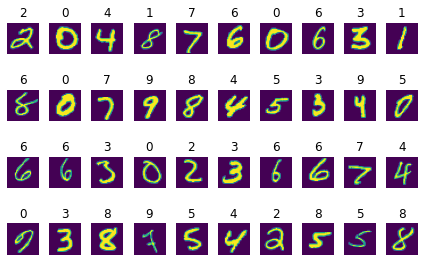

In [1255]:
N_test = 40
P0 = np.argmax(forward_net(X_data_test[:N_test], W, B), axis=1)
im = X_data_test[:N_test].reshape(N_test, 28, 28)

fig, axs = plt.subplots(4, 10)
Is = 0
for i in range(4):
    for k in range(10):
        axs[i, k].imshow(im[Is])
        axs[i, k].set_title(P0[Is])
        axs[i, k].set_axis_off()
        Is += 1
fig.tight_layout()

# thank you for reading